### **Curating visium_slide7.h5ad**

Article:   A human embryonic limb cell atlas resolved in space and time

DOI: https://doi.org/10.1038/s41586-023-06806-x

Data Source : https://developmental.cellatlas.io/embryonic-limb

##### **Packages required for curation**

In [1]:
#Import all packages required for curation

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from tqdm import tqdm
from scipy import sparse
from scipy.sparse import csr_matrix
import anndata as ad
import os
import subprocess
import math
import squidpy as sq
from PIL import Image
from pyometiff import OMETIFFReader

### **Curation Schema**

##### **X (Matrix Layers)**

##### **AnnData object**

In [3]:
# Load the AnnData object

In [4]:
folder = '/nfs/team205/ph12/190308Hongbohindlimb/210124LizVisium/WSSS_THYst9699525/outs'

#REQUIRED to include background spots, so specify raw_feature_bc_matrix.h5
adata = sq.read.visium(folder, counts_file='raw_feature_bc_matrix.h5')


/nfs/users/nfs_s/sa32/anaconda/envs/shibla_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/users/nfs_s/sa32/anaconda/envs/shibla_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 4992 × 33694
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
# Check if adata.X is a sparse matrix
if scipy.sparse.issparse(adata.X):
    # For sparse matrices, use the count_nonzero method of sparse matrices
    non_zero_counts = adata.X.getnnz(axis=1)
else:
    # For dense matrices, use np.count_nonzero
    non_zero_counts = np.count_nonzero(adata.X, axis=1)

# Filter observations based on the condition 'in_tissue' == 1
non_zero_counts_in_tissue = non_zero_counts[adata.obs['in_tissue'] == 1]

# Add this information to adata.obs
adata.obs['non_zero_counts'] = non_zero_counts

# Check for any zero values
any_zero_values = (non_zero_counts_in_tissue == 0).any()

if any_zero_values:
    print("There are zero values in 'non_zero_counts' for observations in tissue.")
else:
    print("There are no zero values in 'non_zero_counts' for observations in tissue.")

# Count the number of zero values
num_zero_values = (non_zero_counts_in_tissue == 0).sum()
num_zero_values


There are no zero values in 'non_zero_counts' for observations in tissue.


0

In [7]:
all_zero_rows = np.asarray(adata.X.sum(axis=1)).flatten() == 0
all_zero_cells_indices = np.where(all_zero_rows)[0]
all_zero_cells = adata[all_zero_cells_indices]
in_tissue_all_zero_cells = all_zero_cells[all_zero_cells.obs['in_tissue'] == 1]
print("Cell names of identified all-zero cells:")
print(all_zero_cells.obs.index.tolist())

Cell names of identified all-zero cells:
['AATAGTCGCGAGTCGG-1', 'CAGTAGCGAGGTAGTA-1', 'CCTAGGTAAAGGTAGC-1', 'GGTGATGAAGGAAGTG-1', 'GGTTGTGTAGCCTGGC-1', 'TGAGGTTGATCCCAAG-1', 'TGGGTTCCCGGACGGA-1']


In [8]:
cell_name = 'AGAAGAGCGCCGTTCC-1'

# Check the value of 'in_tissue' for the specified cell
in_tissue_value = adata.obs.loc[cell_name, 'in_tissue']

print("Value of 'in_tissue' for cell '{}': {}".format(cell_name, in_tissue_value))


Value of 'in_tissue' for cell 'AGAAGAGCGCCGTTCC-1': 0


In [9]:
cell_name = 'AGAAGAGCGCCGTTCC-1'

# Check the value of 'in_tissue' for the specified cell
in_tissue_value = adata.obs.loc[cell_name, 'non_zero_counts']

print("Value of 'non_zero_counts' for cell '{}': {}".format(cell_name, in_tissue_value))


Value of 'non_zero_counts' for cell 'AGAAGAGCGCCGTTCC-1': 14


In [10]:
#SpaceRanger will not output spots that have zero reads mapped, so fill those in with 0s, if needed
if adata.obs.shape[0] < 4992:
    all_barcodes = pd.read_csv(folder + '/spatial/tissue_positions_list.csv', header=None)
    missing_barcodes = all_barcodes[all_barcodes[0].isin(list(adata.obs.index)) == False]
    missing_barcodes.set_index(0, inplace=True)
    missing_barcodes.rename(columns={1: 'in_tissue', 2:'array_row', 3:'array_col'}, inplace=True)
    empty_matrix = sparse.csr_matrix((missing_barcodes.shape[0], adata.var.shape[0]))
    missing_adata = ad.AnnData(empty_matrix, var=adata.var, obs=missing_barcodes[['in_tissue','array_row','array_col']])
    comb_adata = ad.concat([adata, missing_adata], uns_merge='first', merge='first')
    comb_adata.obsm['spatial'] = np.concatenate((adata.obsm['spatial'],missing_barcodes[[5,4]].values))
    adata = comb_adata

In [11]:
adata

AnnData object with n_obs × n_vars = 4992 × 33694
    obs: 'in_tissue', 'array_row', 'array_col', 'non_zero_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

##### **X- expression matrix**

In [12]:
adata.X

<4992x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 6398240 stored elements in Compressed Sparse Row format>

In [13]:
print(adata.X)

  (0, 4129)	1.0
  (0, 5088)	1.0
  (0, 7246)	1.0
  (0, 7966)	1.0
  (0, 10780)	1.0
  (0, 13864)	1.0
  (0, 17906)	1.0
  (0, 30969)	1.0
  (1, 8)	1.0
  (1, 58)	1.0
  (1, 97)	1.0
  (1, 112)	1.0
  (1, 125)	1.0
  (1, 153)	11.0
  (1, 194)	1.0
  (1, 197)	2.0
  (1, 264)	1.0
  (1, 305)	1.0
  (1, 385)	1.0
  (1, 406)	1.0
  (1, 442)	1.0
  (1, 474)	1.0
  (1, 482)	1.0
  (1, 484)	15.0
  (1, 495)	2.0
  :	:
  (4991, 32191)	2.0
  (4991, 32338)	1.0
  (4991, 32419)	1.0
  (4991, 32681)	1.0
  (4991, 32810)	1.0
  (4991, 32858)	1.0
  (4991, 32862)	1.0
  (4991, 32888)	1.0
  (4991, 32919)	3.0
  (4991, 32925)	2.0
  (4991, 32945)	1.0
  (4991, 32979)	1.0
  (4991, 33122)	1.0
  (4991, 33144)	1.0
  (4991, 33359)	1.0
  (4991, 33431)	1.0
  (4991, 33476)	1.0
  (4991, 33621)	1.0
  (4991, 33624)	1.0
  (4991, 33654)	2.0
  (4991, 33655)	1.0
  (4991, 33657)	1.0
  (4991, 33658)	6.0
  (4991, 33659)	1.0
  (4991, 33661)	3.0


##### **Variables(var)**

In [14]:
adata.var

,gene_ids,feature_types,genome
RP11-34P13.3,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
RP11-34P13.7,ENSG00000238009,Gene Expression,GRCh38
RP11-34P13.8,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [15]:
adata.var.set_index('gene_ids', inplace=True)

In [16]:
adata.var

,feature_types,genome
gene_ids,,
ENSG00000243485,Gene Expression,GRCh38
ENSG00000237613,Gene Expression,GRCh38
ENSG00000186092,Gene Expression,GRCh38
ENSG00000238009,Gene Expression,GRCh38
ENSG00000239945,Gene Expression,GRCh38
...,...,...
ENSG00000277856,Gene Expression,GRCh38
ENSG00000275063,Gene Expression,GRCh38
ENSG00000271254,Gene Expression,GRCh38


In [17]:
approved_genes = pd.read_csv('/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/Endometrium_reference_integrated_atlas/genes_approved.csv')

In [18]:
genedict = {key: 1 for key in list(approved_genes.feature_id)}

In [19]:
var_to_keep_adata = [x for x in adata.var_names if (x in genedict)]

In [20]:
adata = adata[:, var_to_keep_adata].copy()

In [21]:
adata.var['feature_is_filtered'] = [False] * len(adata.var)

In [22]:
adata.var

,feature_types,genome,feature_is_filtered
gene_ids,,,
ENSG00000243485,Gene Expression,GRCh38,False
ENSG00000237613,Gene Expression,GRCh38,False
ENSG00000186092,Gene Expression,GRCh38,False
ENSG00000238009,Gene Expression,GRCh38,False
ENSG00000239945,Gene Expression,GRCh38,False
...,...,...,...
ENSG00000277856,Gene Expression,GRCh38,False
ENSG00000275063,Gene Expression,GRCh38,False
ENSG00000271254,Gene Expression,GRCh38,False


In [23]:
del adata.var['feature_types']
del adata.var['genome']

#### **Observations(obs) (Cell metadata)**

In [24]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts
AAACAACGAATAGTTC-1,0,0,16,8
AAACAAGTATCTCCCA-1,0,50,102,1286
AAACAATCTACTAGCA-1,0,3,43,43
AAACACCAATAACTGC-1,0,59,19,24
AAACAGAGCGACTCCT-1,1,14,94,3714
...,...,...,...,...
TTGTTTCACATCCAGG-1,0,58,42,2901
TTGTTTCATTAGTCTA-1,0,60,30,356
TTGTTTCCATACAACT-1,0,45,27,128
TTGTTTGTATTACACG-1,1,73,41,2232


#### **assay_ontology_term_id**

In [25]:
adata.obs['assay_ontology_term_id'] = 'EFO:0010961'

In [26]:
adata.obs['assay_ontology_term_id'] = adata.obs['assay_ontology_term_id'].astype('category')

#### **cell_type_ontology_term_id**

In [27]:
adata1 = sc.read_h5ad('/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/limb_cell_atlas/Final_objects/spatial_h5ad_final_objects/visium_slide7.h5ad')

In [28]:
adata1.obs

,in_tissue,percent_mito,C2L: ADH+Fibro,C2L: AER-Basal,C2L: ArterialEndo,C2L: ArtiChon,C2L: B,C2L: Basal,C2L: CMP/GMP,C2L: ChondroProg,...,stage,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
AAACAGAGCGACTCCT-1_WSSS_THYst9699525,1,0.0,0.001751,1.541157,0.004359,0.002649,0.001065,1.483553,0.002090,0.009983,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
AAACAGTGTTCCTGGG-1_WSSS_THYst9699525,1,0.0,0.000477,0.001525,0.000017,0.000268,0.000138,0.000376,0.000137,0.001281,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
AAACATTTCCCGGATT-1_WSSS_THYst9699525,1,0.0,0.000242,0.001744,0.000060,0.002066,0.010673,0.000945,0.000676,0.454696,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
AAACCTAAGCAGCCGG-1_WSSS_THYst9699525,1,0.0,0.000575,0.000530,0.000050,0.009610,0.016221,0.000696,0.001457,0.027216,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
AAACGGGCGTACGGGT-1_WSSS_THYst9699525,1,0.0,0.000731,0.000610,0.000220,0.010200,0.021439,0.000825,0.002353,0.013453,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGGTGGTACTAAG-1_WSSS_THYst9699525,1,0.0,0.000785,0.000700,0.000632,0.013754,0.028640,0.000680,0.001986,0.044713,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
TTGTGTATGCCACCAA-1_WSSS_THYst9699525,1,0.0,0.005870,0.013089,0.009438,0.001672,0.002985,0.006463,0.001550,0.009358,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
TTGTTCAGTGTGCTAC-1_WSSS_THYst9699525,1,0.0,0.000127,0.003779,0.084643,0.000215,0.005103,0.001651,0.000281,0.001404,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978
TTGTTGTGTGTCAAGA-1_WSSS_THYst9699525,1,0.0,0.000108,1.207687,0.000048,0.000305,0.003516,0.290963,0.000717,0.001661,...,PCW6.2,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978


In [29]:
adata1.obs.columns

Index(['in_tissue', 'percent_mito', 'C2L: ADH+Fibro', 'C2L: AER-Basal',
       'C2L: ArterialEndo', 'C2L: ArtiChon', 'C2L: B', 'C2L: Basal',
       'C2L: CMP/GMP', 'C2L: ChondroProg', 'C2L: DC2', 'C2L: DefErythro',
       'C2L: DefReticulo', 'C2L: DermFibro', 'C2L: DistalMes',
       'C2L: F10+DermFibroProg', 'C2L: HOXC5+DermFibroProg', 'C2L: HyperChon',
       'C2L: ISL1+Mes', 'C2L: InterMusFibro', 'C2L: InterZone',
       'C2L: LMPP/ELP', 'C2L: LymphEndo', 'C2L: MFAP5+Fibro', 'C2L: MYH3+MyoC',
       'C2L: MYL3+MyoC', 'C2L: Macro', 'C2L: Mast', 'C2L: Megakaryo',
       'C2L: Melano', 'C2L: Mes1', 'C2L: Mes2', 'C2L: Mes3', 'C2L: Mes4',
       'C2L: MesCond', 'C2L: Monocyte', 'C2L: Myelocyte', 'C2L: MyoB1',
       'C2L: MyoB2', 'C2L: MyoC1', 'C2L: MyoC2', 'C2L: NK', 'C2L: NeuralFibro',
       'C2L: Neuronal', 'C2L: OCP', 'C2L: OsteoB', 'C2L: PAX3+MyoProg',
       'C2L: PAX7+MyoProg', 'C2L: Perichon', 'C2L: Pericyte', 'C2L: Periderm',
       'C2L: Perimysium', 'C2L: PrehyperChon', 'C2L:

In [30]:
adata1.obs['barcodes'] = adata1.obs_names
adata1.obs['barcodes'] = adata1.obs['barcodes'].str.extract(r'([ATGC]{10,16})', expand=False)

In [31]:
adata1.obs

,in_tissue,percent_mito,C2L: ADH+Fibro,C2L: AER-Basal,C2L: ArterialEndo,C2L: ArtiChon,C2L: B,C2L: Basal,C2L: CMP/GMP,C2L: ChondroProg,...,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id,barcodes
AAACAGAGCGACTCCT-1_WSSS_THYst9699525,1,0.0,0.001751,1.541157,0.004359,0.002649,0.001065,1.483553,0.002090,0.009983,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,AAACAGAGCGACTCCT
AAACAGTGTTCCTGGG-1_WSSS_THYst9699525,1,0.0,0.000477,0.001525,0.000017,0.000268,0.000138,0.000376,0.000137,0.001281,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,AAACAGTGTTCCTGGG
AAACATTTCCCGGATT-1_WSSS_THYst9699525,1,0.0,0.000242,0.001744,0.000060,0.002066,0.010673,0.000945,0.000676,0.454696,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,AAACATTTCCCGGATT
AAACCTAAGCAGCCGG-1_WSSS_THYst9699525,1,0.0,0.000575,0.000530,0.000050,0.009610,0.016221,0.000696,0.001457,0.027216,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,AAACCTAAGCAGCCGG
AAACGGGCGTACGGGT-1_WSSS_THYst9699525,1,0.0,0.000731,0.000610,0.000220,0.010200,0.021439,0.000825,0.002353,0.013453,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,AAACGGGCGTACGGGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGGTGGTACTAAG-1_WSSS_THYst9699525,1,0.0,0.000785,0.000700,0.000632,0.013754,0.028640,0.000680,0.001986,0.044713,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,TTGTGGTGGTACTAAG
TTGTGTATGCCACCAA-1_WSSS_THYst9699525,1,0.0,0.005870,0.013089,0.009438,0.001672,0.002985,0.006463,0.001550,0.009358,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,TTGTGTATGCCACCAA
TTGTTCAGTGTGCTAC-1_WSSS_THYst9699525,1,0.0,0.000127,0.003779,0.084643,0.000215,0.005103,0.001651,0.000281,0.001404,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,TTGTTCAGTGTGCTAC
TTGTTGTGTGTCAAGA-1_WSSS_THYst9699525,1,0.0,0.000108,1.207687,0.000048,0.000305,0.003516,0.290963,0.000717,0.001661,...,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0000978,TTGTTGTGTGTCAAGA


In [32]:
# Ensure 'barcode' and 'cell_type_ontology_term_id' are columns in adata.obs
if 'barcodes' in adata1.obs.columns and 'cell_type_ontology_term_id' in adata1.obs.columns:
    # Create the dictionary
    mapping = dict(zip(adata1.obs['barcodes'], adata1.obs['cell_type_ontology_term_id']))
else:
    raise KeyError("Columns 'barcode' and/or 'cell_type_ontology_term_id' not found in adata1.obs")


In [33]:
mapping

{'AAACAGAGCGACTCCT': 'CL:0002551',
 'AAACAGTGTTCCTGGG': 'CL:0008019',
 'AAACATTTCCCGGATT': 'CL:0008019',
 'AAACCTAAGCAGCCGG': 'CL:0000138',
 'AAACGGGCGTACGGGT': 'CL:0000138',
 'AAACGGTTGCGAACTG': 'CL:0008019',
 'AAACGTGTTCGCCCTA': 'CL:0008019',
 'AAACTAACGTGGCGAC': 'CL:0002551',
 'AAACTCGGTTCGCAAT': 'CL:0000187',
 'AAACTCGTGATATAAG': 'CL:0002551',
 'AAAGGCTACGGACCAT': 'CL:0000187',
 'AAAGGCTCTCGCGCCG': 'CL:0002551',
 'AAAGGGATGTAGCAAG': 'CL:0008019',
 'AAAGGTAAGCTGTACC': 'CL:0002551',
 'AAATCCGATACACGCC': 'CL:0008019',
 'AAATCTAGCCCTGCTA': 'CL:0008019',
 'AAATGATTCGATCAGC': 'CL:0000187',
 'AAATTACCTATCGATG': 'CL:0000138',
 'AAATTGGTGAGAAGCA': 'CL:0008019',
 'AACAATACATTGTCGA': 'CL:0002551',
 'AACACACGCTCGCCGC': 'CL:0008019',
 'AACAGGAAATCGAATA': 'CL:0008019',
 'AACATATCAACTGGTG': 'CL:0002551',
 'AACATCGATACGTCTA': 'CL:0008019',
 'AACATTGTGACTCGAG': 'CL:0000187',
 'AACCCGACAACCCGTG': 'CL:0008019',
 'AACCCGCTGTATTCCA': 'CL:0002551',
 'AACCGAGCTTGGTCAT': 'CL:0000138',
 'AACCGTTGTGTTTGCT':

In [34]:
adata.obs['barcodes'] = adata.obs_names
adata.obs['barcodes'] = adata.obs['barcodes'].str.extract(r'([ATGC]{10,16})', expand=False)

In [35]:
adata.obs['cell_type_ontology_term_id'] = adata.obs['barcodes'].map(mapping)

In [36]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id
AAACAACGAATAGTTC-1,0,0,16,8,EFO:0010961,AAACAACGAATAGTTC,NaN
AAACAAGTATCTCCCA-1,0,50,102,1286,EFO:0010961,AAACAAGTATCTCCCA,NaN
AAACAATCTACTAGCA-1,0,3,43,43,EFO:0010961,AAACAATCTACTAGCA,NaN
AAACACCAATAACTGC-1,0,59,19,24,EFO:0010961,AAACACCAATAACTGC,NaN
AAACAGAGCGACTCCT-1,1,14,94,3714,EFO:0010961,AAACAGAGCGACTCCT,CL:0002551
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0,58,42,2901,EFO:0010961,TTGTTTCACATCCAGG,NaN
TTGTTTCATTAGTCTA-1,0,60,30,356,EFO:0010961,TTGTTTCATTAGTCTA,NaN
TTGTTTCCATACAACT-1,0,45,27,128,EFO:0010961,TTGTTTCCATACAACT,NaN
TTGTTTGTATTACACG-1,1,73,41,2232,EFO:0010961,TTGTTTGTATTACACG,CL:0000138


In [37]:
num_nans = adata.obs['cell_type_ontology_term_id'].isna().sum()
num_nans

3611

In [38]:
adata.obs['cell_type_ontology_term_id'].fillna('unknown', inplace=True)

/tmp/ipykernel_31959/2352945792.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['cell_type_ontology_term_id'].fillna('unknown', inplace=True)


In [39]:
num_nans = adata.obs['cell_type_ontology_term_id'].isna().sum()
num_nans

0

In [40]:
adata.obs['cell_type_ontology_term_id'] = adata.obs['cell_type_ontology_term_id'].astype('category')

In [41]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id
AAACAACGAATAGTTC-1,0,0,16,8,EFO:0010961,AAACAACGAATAGTTC,unknown
AAACAAGTATCTCCCA-1,0,50,102,1286,EFO:0010961,AAACAAGTATCTCCCA,unknown
AAACAATCTACTAGCA-1,0,3,43,43,EFO:0010961,AAACAATCTACTAGCA,unknown
AAACACCAATAACTGC-1,0,59,19,24,EFO:0010961,AAACACCAATAACTGC,unknown
AAACAGAGCGACTCCT-1,1,14,94,3714,EFO:0010961,AAACAGAGCGACTCCT,CL:0002551
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0,58,42,2901,EFO:0010961,TTGTTTCACATCCAGG,unknown
TTGTTTCATTAGTCTA-1,0,60,30,356,EFO:0010961,TTGTTTCATTAGTCTA,unknown
TTGTTTCCATACAACT-1,0,45,27,128,EFO:0010961,TTGTTTCCATACAACT,unknown
TTGTTTGTATTACACG-1,1,73,41,2232,EFO:0010961,TTGTTTGTATTACACG,CL:0000138


In [42]:
list(adata.obs['cell_type_ontology_term_id'].unique())

['unknown',
 'CL:0002551',
 'CL:0008019',
 'CL:0000138',
 'CL:0000187',
 'CL:0000515',
 'CL:0000388',
 'CL:0000646',
 'CL:0000058',
 'CL:0002355',
 'CL:0002573']

#### **donor_id**

In [43]:
unique_value = adata1.obs['donor_id'].unique()[0]
unique_value 
adata.obs['donor_id'] = unique_value

In [44]:
adata.obs['donor_id'] = adata.obs['donor_id'].astype('category')

#### **development_stage_ontology_term_id**

In [45]:
unique_value = adata1.obs['development_stage_ontology_term_id'].unique()[0]
unique_value 
adata.obs['development_stage_ontology_term_id'] = unique_value

In [46]:
list(adata.obs['development_stage_ontology_term_id'].unique())

['HsapDv:0000024']

In [47]:
adata.obs['development_stage_ontology_term_id'] = adata.obs['development_stage_ontology_term_id'].astype('category')

In [48]:
adata.obs['development_stage_ontology_term_id']

AAACAACGAATAGTTC-1    HsapDv:0000024
AAACAAGTATCTCCCA-1    HsapDv:0000024
AAACAATCTACTAGCA-1    HsapDv:0000024
AAACACCAATAACTGC-1    HsapDv:0000024
AAACAGAGCGACTCCT-1    HsapDv:0000024
                           ...      
TTGTTTCACATCCAGG-1    HsapDv:0000024
TTGTTTCATTAGTCTA-1    HsapDv:0000024
TTGTTTCCATACAACT-1    HsapDv:0000024
TTGTTTGTATTACACG-1    HsapDv:0000024
TTGTTTGTGTAAATTC-1    HsapDv:0000024
Name: development_stage_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['HsapDv:0000024']

#### **disease_ontology_term_id**

In [49]:
unique_value = adata1.obs['disease_ontology_term_id'].unique()[0]
unique_value 
adata.obs['disease_ontology_term_id'] = unique_value

In [50]:
adata.obs['disease_ontology_term_id'] = adata.obs['disease_ontology_term_id'].astype('category')

In [51]:
adata.obs['disease_ontology_term_id']

AAACAACGAATAGTTC-1    PATO:0000461
AAACAAGTATCTCCCA-1    PATO:0000461
AAACAATCTACTAGCA-1    PATO:0000461
AAACACCAATAACTGC-1    PATO:0000461
AAACAGAGCGACTCCT-1    PATO:0000461
                          ...     
TTGTTTCACATCCAGG-1    PATO:0000461
TTGTTTCATTAGTCTA-1    PATO:0000461
TTGTTTCCATACAACT-1    PATO:0000461
TTGTTTGTATTACACG-1    PATO:0000461
TTGTTTGTGTAAATTC-1    PATO:0000461
Name: disease_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['PATO:0000461']

#### **is_primary_data**

In [52]:
unique_value = adata1.obs['is_primary_data'].unique()[0]
unique_value 
adata.obs['is_primary_data'] = unique_value

In [53]:
adata.obs['is_primary_data'] = adata.obs['is_primary_data'].astype('bool')

In [54]:
adata.obs['is_primary_data']

AAACAACGAATAGTTC-1    True
AAACAAGTATCTCCCA-1    True
AAACAATCTACTAGCA-1    True
AAACACCAATAACTGC-1    True
AAACAGAGCGACTCCT-1    True
                      ... 
TTGTTTCACATCCAGG-1    True
TTGTTTCATTAGTCTA-1    True
TTGTTTCCATACAACT-1    True
TTGTTTGTATTACACG-1    True
TTGTTTGTGTAAATTC-1    True
Name: is_primary_data, Length: 4992, dtype: bool

#### **organism_ontology_term_id**

In [55]:
unique_value = adata1.obs['organism_ontology_term_id'].unique()[0]
unique_value 
adata.obs['organism_ontology_term_id'] = unique_value

In [56]:
adata.obs['organism_ontology_term_id'] = adata.obs['organism_ontology_term_id'].astype('category')

In [57]:
adata.obs['organism_ontology_term_id']

AAACAACGAATAGTTC-1    NCBITaxon:9606
AAACAAGTATCTCCCA-1    NCBITaxon:9606
AAACAATCTACTAGCA-1    NCBITaxon:9606
AAACACCAATAACTGC-1    NCBITaxon:9606
AAACAGAGCGACTCCT-1    NCBITaxon:9606
                           ...      
TTGTTTCACATCCAGG-1    NCBITaxon:9606
TTGTTTCATTAGTCTA-1    NCBITaxon:9606
TTGTTTCCATACAACT-1    NCBITaxon:9606
TTGTTTGTATTACACG-1    NCBITaxon:9606
TTGTTTGTGTAAATTC-1    NCBITaxon:9606
Name: organism_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['NCBITaxon:9606']

#### **self_reported_ethnicity_ontology_term_id**

In [58]:
unique_value = adata1.obs['self_reported_ethnicity_ontology_term_id'].unique()[0]
unique_value 
adata.obs['self_reported_ethnicity_ontology_term_id'] = unique_value

In [59]:
adata.obs['self_reported_ethnicity_ontology_term_id'] = adata.obs['self_reported_ethnicity_ontology_term_id'].astype('category')

In [60]:
adata.obs['self_reported_ethnicity_ontology_term_id']

AAACAACGAATAGTTC-1    unknown
AAACAAGTATCTCCCA-1    unknown
AAACAATCTACTAGCA-1    unknown
AAACACCAATAACTGC-1    unknown
AAACAGAGCGACTCCT-1    unknown
                       ...   
TTGTTTCACATCCAGG-1    unknown
TTGTTTCATTAGTCTA-1    unknown
TTGTTTCCATACAACT-1    unknown
TTGTTTGTATTACACG-1    unknown
TTGTTTGTGTAAATTC-1    unknown
Name: self_reported_ethnicity_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['unknown']

#### **sex_ontology_term_id**

In [61]:
unique_value = adata1.obs['sex_ontology_term_id'].unique()[0]
unique_value 
adata.obs['sex_ontology_term_id'] = unique_value

In [62]:
adata.obs['sex_ontology_term_id'] = adata.obs['sex_ontology_term_id'].astype('category')

In [63]:
adata.obs['sex_ontology_term_id']

AAACAACGAATAGTTC-1    PATO:0000384
AAACAAGTATCTCCCA-1    PATO:0000384
AAACAATCTACTAGCA-1    PATO:0000384
AAACACCAATAACTGC-1    PATO:0000384
AAACAGAGCGACTCCT-1    PATO:0000384
                          ...     
TTGTTTCACATCCAGG-1    PATO:0000384
TTGTTTCATTAGTCTA-1    PATO:0000384
TTGTTTCCATACAACT-1    PATO:0000384
TTGTTTGTATTACACG-1    PATO:0000384
TTGTTTGTGTAAATTC-1    PATO:0000384
Name: sex_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['PATO:0000384']

#### **suspension_type**

In [64]:
adata.obs['suspension_type'] = 'na'

In [65]:
adata.obs['suspension_type'] = adata.obs['suspension_type'].astype('category')

#### **tissue_type**

In [66]:
unique_value = adata1.obs['tissue_type'].unique()[0]
unique_value 
adata.obs['tissue_type'] = unique_value

In [67]:
adata.obs['tissue_type'] = adata.obs['tissue_type'].astype('category')

#### **tissue_ontology_term_id**

In [68]:
unique_value = adata1.obs['tissue_ontology_term_id'].unique()[0]
unique_value 
adata.obs['tissue_ontology_term_id'] = "UBERON:0002103"

In [69]:
adata.obs['tissue_ontology_term_id'] = adata.obs['tissue_ontology_term_id'].astype('category')

In [70]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id,donor_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
AAACAACGAATAGTTC-1,0,0,16,8,EFO:0010961,AAACAACGAATAGTTC,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACAAGTATCTCCCA-1,0,50,102,1286,EFO:0010961,AAACAAGTATCTCCCA,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACAATCTACTAGCA-1,0,3,43,43,EFO:0010961,AAACAATCTACTAGCA,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACACCAATAACTGC-1,0,59,19,24,EFO:0010961,AAACACCAATAACTGC,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACAGAGCGACTCCT-1,1,14,94,3714,EFO:0010961,AAACAGAGCGACTCCT,CL:0002551,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0,58,42,2901,EFO:0010961,TTGTTTCACATCCAGG,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
TTGTTTCATTAGTCTA-1,0,60,30,356,EFO:0010961,TTGTTTCATTAGTCTA,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
TTGTTTCCATACAACT-1,0,45,27,128,EFO:0010961,TTGTTTCCATACAACT,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
TTGTTTGTATTACACG-1,1,73,41,2232,EFO:0010961,TTGTTTGTATTACACG,CL:0000138,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103


#### **obsm (Embeddings)**

In [71]:
adata.obsm

AxisArrays with keys: spatial

In [72]:
#adata.obsm['X_spatial'] = adata.obsm['spatial']

#### **uns (Dataset Metadata)**

In [73]:
adata.uns

OrderedDict([('spatial',
              {'WSSS_THYst9699525': {'metadata': {'chemistry_description': "Spatial 3' v1",
                 'software_version': '4.0'},
                'images': {'hires': array([[[237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239],
                         ...,
                         [237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239]],
                 
                        [[237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239],
                         ...,
                         [237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239]],
                 
                        [[237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239],
                         ...,
                         [237, 235, 239],
                   

In [74]:
adata.uns['image_caption'] = 'Shown here is an image of ten micron thick cryosections of whole embryonic limb samples stained with H&E'

In [75]:
adata.uns['default_embedding'] = 'spatial'

In [76]:
library_id = list(adata.uns['spatial'].keys())[0]

In [77]:
#REQUIRED to distinguish single section data from integrated data
adata.uns['spatial']['is_single'] = True

In [78]:
#PREFERRED to include fullres image
#this is a SpaceRanger input, not an output
fullres_path = '/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/limb_cell_atlas/Data/Full_res_image/WSSS_THYst9699525.tif'

#some of the fullres images require expanding the limit
Image.MAX_IMAGE_PIXELS = 699408640

#.ome.tif examples - https://www.heartcellatlas.org/
if fullres_path.endswith('.ome.tif'):
    reader = OMETIFFReader(fpath=fullres_path)
    fullres_np, metadata, xml_metadata = reader.read()

    #may need to transpose the image if its an invalid shape
    fullres_np = np.transpose(fullres_np, (1,2,0))

    sr_adata.uns['spatial'][library_id]['images']['fullres'] = fullres_np

    #optional to store image metadata in the dataset
    sr_adata.uns['fullres_xml_metadata'] = xml_metadata
elif fullres_path.split('.')[-1] in ['tif','tiff','jpg']:
    fullres_np = np.asarray(Image.open(fullres_path))

#may need to rotate the image to align with embeddings
#k is the number of times to rotate the image 90 degrees counter-clockwise
fullres_np  = np.rot90(fullres_np, k=3)
fullres_np  = np.rot90(fullres_np, k=1)
adata.uns['spatial'][library_id]['images']['fullres'] = fullres_np

In [79]:
adata.uns['title'] = library_id

In [80]:
#OPTIONAL to move metadata before deleting it
adata.uns['spatial_metadata'] = adata.uns['spatial'][library_id]['metadata']

#MUST NOT SUBMIT metadata or lowres or fiducial_diameter_fullres in uns.spatial
del adata.uns['spatial'][library_id]['metadata']
del adata.uns['spatial'][library_id]['images']['lowres']
del adata.uns['spatial'][library_id]['scalefactors']['tissue_lowres_scalef']
del adata.uns['spatial'][library_id]['scalefactors']['fiducial_diameter_fullres']

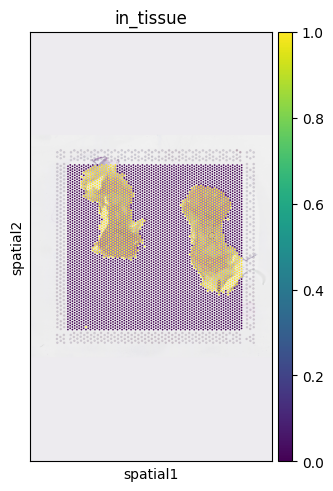

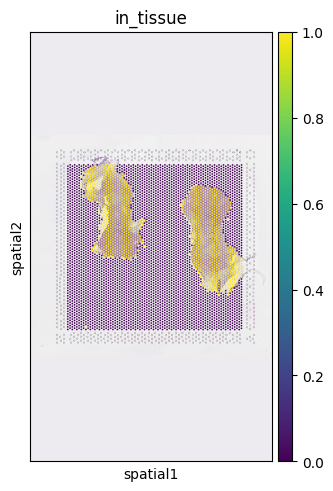

In [81]:
#QA by plotting with the hires image
sq.pl.spatial_scatter(
    adata,
    library_id=library_id,
    color='in_tissue'
)

#same plot with fullres image, if present
if 'fullres' in adata.uns['spatial'][library_id]['images']:
    sq.pl.spatial_scatter(
        adata,
        library_id=library_id,
        color='in_tissue',
        img_res_key='fullres',
        scale_factor=1.0
        )

In [82]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id,donor_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
AAACAACGAATAGTTC-1,0,0,16,8,EFO:0010961,AAACAACGAATAGTTC,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACAAGTATCTCCCA-1,0,50,102,1286,EFO:0010961,AAACAAGTATCTCCCA,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACAATCTACTAGCA-1,0,3,43,43,EFO:0010961,AAACAATCTACTAGCA,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACACCAATAACTGC-1,0,59,19,24,EFO:0010961,AAACACCAATAACTGC,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
AAACAGAGCGACTCCT-1,1,14,94,3714,EFO:0010961,AAACAGAGCGACTCCT,CL:0002551,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0,58,42,2901,EFO:0010961,TTGTTTCACATCCAGG,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
TTGTTTCATTAGTCTA-1,0,60,30,356,EFO:0010961,TTGTTTCATTAGTCTA,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
TTGTTTCCATACAACT-1,0,45,27,128,EFO:0010961,TTGTTTCCATACAACT,unknown,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103
TTGTTTGTATTACACG-1,1,73,41,2232,EFO:0010961,TTGTTTGTATTACACG,CL:0000138,WSSS_THYst9699525,HsapDv:0000024,PATO:0000461,True,NCBITaxon:9606,unknown,PATO:0000384,na,tissue,UBERON:0002103


In [83]:
del adata.obs['barcodes']

In [84]:
adata.obsm

AxisArrays with keys: spatial

In [85]:
#del adata.obsm['X_spatial']

In [86]:
adata.var

,feature_is_filtered
gene_ids,
ENSG00000243485,False
ENSG00000237613,False
ENSG00000186092,False
ENSG00000238009,False
ENSG00000239945,False
...,...
ENSG00000277856,False
ENSG00000275063,False
ENSG00000271254,False


In [87]:
adata.uns

OrderedDict([('spatial',
              {'WSSS_THYst9699525': {'images': {'hires': array([[[237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239],
                         ...,
                         [237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239]],
                 
                        [[237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239],
                         ...,
                         [237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239]],
                 
                        [[237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239],
                         ...,
                         [237, 235, 239],
                         [237, 235, 239],
                         [237, 235, 239]],
                 
                        ...,
   

In [88]:
adata.write('/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/limb_cell_atlas/Final_objects/to_upload/visium_slide7.h5ad', compression = 'gzip')